# Task 1, 3 - fastai interface to ingest models from pytorch model zoo

In [1]:
from fastai.vision.all import *

## 1.1 - Set data loading params

In [2]:
path = untar_data(URLs.PETS)/'images'
fnames = get_image_files(path)
pat = r'/([^/]+)_\d+.*'

In [3]:
batch_tfms = [*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.))
bs=64

In [4]:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 get_y=RegexLabeller(pat = r'/([^/]+)_\d+.*'),
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms)

In [5]:
dls = pets.dataloaders(path,path=path, bs=bs)

In [6]:
dls.c # number of categories

37

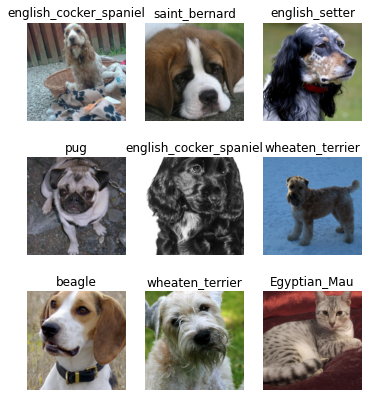

In [7]:
dls.show_batch(max_n=9, figsize=(6,7))

## 1.2 - Initialize learner model

In [8]:
learn = cnn_learner(dls, resnet18) # using fastai built-in model

Notice the learner model only works with head and body parts:

In [9]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

We can see that our fastai model was split into two different layer groups:

    Group 1: Our encoder, which is everything but the last layer of our original model
    Group 2: Our head, which is a fastai version of a Linear layer plus a few extra bits



## 1.3 - Get pretrained model

In [10]:
from timm import create_model

In [11]:
import timm
from pprint import pprint
model_names = timm.list_models(pretrained=True)
pprint(model_names)

['adv_inception_v3',
 'cspdarknet53',
 'cspresnet50',
 'cspresnext50',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'densenetblur121d',
 'dla34',
 'dla46_c',
 'dla46x_c',
 'dla60',
 'dla60_res2net',
 'dla60_res2next',
 'dla60x',
 'dla60x_c',
 'dla102',
 'dla102x',
 'dla102x2',
 'dla169',
 'dpn68',
 'dpn68b',
 'dpn92',
 'dpn98',
 'dpn107',
 'dpn131',
 'ecaresnet50d',
 'ecaresnet50d_pruned',
 'ecaresnet101d',
 'ecaresnet101d_pruned',
 'ecaresnetlight',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b1_pruned',
 'efficientnet_b2',
 'efficientnet_b2_pruned',
 'efficientnet_b2a',
 'efficientnet_b3',
 'efficientnet_b3_pruned',
 'efficientnet_b3a',
 'efficientnet_em',
 'efficientnet_es',
 'efficientnet_lite0',
 'ens_adv_inception_resnet_v2',
 'ese_vovnet19b_dw',
 'ese_vovnet39b',
 'fbnetc_100',
 'gluon_inception_v3',
 'gluon_resnet18_v1b',
 'gluon_resnet34_v1b',
 'gluon_resnet50_v1b',
 'gluon_resnet50_v1c',
 'gluon_resnet50_v1d',
 'gluon_resnet50_v1s',
 'gluon_resn

In [12]:
net = create_model('resnet18', pretrained=True) #load pretrained models elsewhere

In [13]:
net.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  ...,  5.6615e-02,
                          1.7083e-02, -1.2694e-02],
                        [ 1.1083e-02,  9.5276e-03, -1.0993e-01,  ..., -2.7124e-01,
                         -1.2907e-01,  3.7424e-03],
                        [-6.9434e-03,  5.9089e-02,  2.9548e-01,  ...,  5.1972e-01,
                          2.5632e-01,  6.3573e-02],
                        ...,
                        [-2.7535e-02,  1.6045e-02,  7.2595e-02,  ..., -3.3285e-01,
                         -4.2058e-01, -2.5781e-01],
                        [ 3.0613e-02,  4.0960e-02,  6.2850e-02,  ...,  4.1384e-01,
                          3.9359e-01,  1.6606e-01],
                        [-1.3736e-02, -3.6746e-03, -2.4084e-02,  ..., -1.5070e-01,
                         -8.2230e-02, -5.7828e-03]],
              
                       [[-1.1397e-02, -2.6619e-02, -3.4641e-02,  ...,  3.2521e-02,
                          6.6221

The model from pytorch only has the head, not the body. Learner interface needs both head and body. 

In [14]:
def create_timm_body(arch:str, pretrained=True, cut=None):
    model = create_model(arch, pretrained=pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or function")

In [15]:
body = create_timm_body('resnet18',pretrained=True)

In [16]:
body

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU

In [17]:
nf = num_features_model(nn.Sequential(*body.children())) * (2); nf

1024

In [18]:
head = create_head(nf, dls.c)
head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=37, bias=False)
)

In [19]:
model = nn.Sequential(body, head) # fastai Learner needs body and head

In [20]:
apply_init(model[1], nn.init.kaiming_normal_)

In [21]:
len(model) # Now we have head and body

2

Great! Now we have both the body commonly received from pretrained model zoos, as well as the head for fastai use. Fastai already allows comfortable imports of these pretrained architectures, in case we have other models we want to use, we can edit them through this way.

In [22]:
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy())

In [23]:
learn.summary()

Sequential (Input shape: ['64 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 112 x 112  9,408      True      
________________________________________________________________
BatchNorm2d          64 x 64 x 112 x 112  128        True      
________________________________________________________________
ReLU                 64 x 64 x 112 x 112  0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 56 x 56    0          False     
________________________________________________________________
Conv2d               64 x 64 x 56 x 56    36,864     True      
________________________________________________________________
BatchNorm2d          64 x 64 x 56 x 56    128        True      
________________________________________________________________
ReLU                 64 x 64 x 56 x 56    0          False     
_________________________________________________

The new model is not frozen, we need to split the model to model[0] (head) and model[1] body - we `use default_split` for this purpose:

In [24]:
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy(), 
                splitter=default_split, metrics=error_rate,
               path=path)

In [25]:
learn.freeze()
learn.summary()

Sequential (Input shape: ['64 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 112 x 112  9,408      False     
________________________________________________________________
BatchNorm2d          64 x 64 x 112 x 112  128        True      
________________________________________________________________
ReLU                 64 x 64 x 112 x 112  0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 56 x 56    0          False     
________________________________________________________________
Conv2d               64 x 64 x 56 x 56    36,864     False     
________________________________________________________________
BatchNorm2d          64 x 64 x 56 x 56    128        True      
________________________________________________________________
ReLU                 64 x 64 x 56 x 56    0          False     
_________________________________________________

Now we find the optimal learning rate, which is roughly at the steepest slope:

SuggestedLRs(lr_min=0.014454397559165954, lr_steep=0.0020892962347716093)

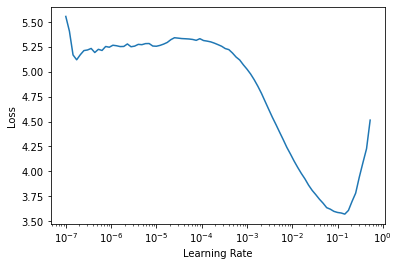

In [26]:
learn.lr_find()

In [27]:
learn.fit_one_cycle(5, slice(3e-2))

epoch,train_loss,valid_loss,error_rate,time
0,1.931458,1.603230,0.207037,00:45
1,1.415657,1.091156,0.115697,00:46
2,1.153144,1.042101,0.104871,00:47
3,1.035820,0.986307,0.091340,00:48
4,0.963770,0.968070,0.081191,00:48


We can use fastai learner to save at the path:

In [28]:
learn.save('cat-0')

Path('/home/hud/.fastai/data/oxford-iiit-pet/images/models/cat-0.pth')

## 1.4 - Convert fastai pytorch to ONNX

We export the fastai model to onnx and evaluate later.

In [29]:
learn.model.eval();
torch.onnx.export(
    learn.model,
    torch.randn(1, 3, 224, 224).cuda(),
    path/"models/pet-breed.onnx",
    input_names=["image"],
    output_names=["breeds"]
)

# Task 5 - Use model-agnostic ONNX runtime for classification

In [30]:
import onnxruntime as rt
import numpy as np

In [31]:
sess = rt.InferenceSession("/home/hud/.fastai/data/oxford-iiit-pet/images/models/pet-breed.onnx")

In [32]:
input_name = sess.get_inputs()[0].name
label_name = sess.get_outputs()[0].name
input_name, label_name

('image', 'breeds')

In [33]:
# run once
!wget https://raw.githubusercontent.com/onnx/onnx-docker/master/onnx-ecosystem/inference_demos/images/dog.jpg

--2020-12-18 14:43:30--  https://raw.githubusercontent.com/onnx/onnx-docker/master/onnx-ecosystem/inference_demos/images/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.24.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.24.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21240 (21K) [image/jpeg]
Saving to: ‘dog.jpg.1’

dog.jpg.1           100%[===================>]  20.74K  --.-KB/s    in 0.006s  

2020-12-18 14:43:30 (3.26 MB/s) - ‘dog.jpg.1’ saved [21240/21240]



In [34]:
labels = dls.vocab.items

def preprocess(input_data):
    # convert the input data into the float32 input
    img_data = input_data.astype('float32')

    #normalize
    mean_vec = np.array([0.485, 0.456, 0.406])
    stddev_vec = np.array([0.229, 0.224, 0.225])
    norm_img_data = np.zeros(img_data.shape).astype('float32')
    for i in range(img_data.shape[0]):
        norm_img_data[i,:,:] = (img_data[i,:,:]/255 - mean_vec[i]) / stddev_vec[i]
        
    #add batch channel
    norm_img_data = norm_img_data.reshape(1, 3, 224, 224).astype('float32')
    return norm_img_data

def softmax(x):
    x = x.reshape(-1)
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def postprocess(result):
    return softmax(np.array(result)).tolist()

Image size:  (224, 224)


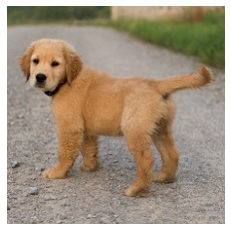

In [35]:
image = PILImage.create(f'dog.jpg')

print("Image size: ", image.size)
plt.axis('off')
display_image = plt.imshow(image)
image_data = np.array(image).transpose(2, 0, 1)
input_data = preprocess(image_data)

In [36]:
start = time.time()
raw_result = sess.run([label_name], {input_name: input_data})
end = time.time()
res = postprocess(raw_result)

Final top prediction is: english_cocker_spaniel
Inference time: 30.07 ms
============ Top 5 labels are: ============================
['english_cocker_spaniel', 'wheaten_terrier', 'great_pyrenees', 'american_pit_bull_terrier', 'pomeranian']


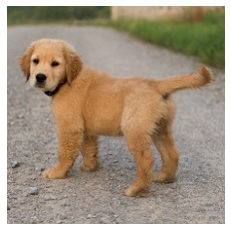

In [37]:
inference_time = np.round((end - start) * 1000, 2)
idx = np.argmax(res)

print('========================================')
print('Final top prediction is: ' + dls.vocab[idx])
print('========================================')

print('========================================')
print('Inference time: ' + str(inference_time) + " ms")
print('========================================')

sort_idx = np.flip(np.squeeze(np.argsort(res)))
print('============ Top 5 labels are: ============================')
print(dls.vocab[sort_idx[:5]])
print('===========================================================')

plt.axis('off')
display_image = plt.imshow(image)

Let's see how that compares with fastai inference

In [38]:
start = time.time()
fastai_res = learn.predict(image, with_input=False)
end = time.time()
inference_time = np.round((end - start) * 1000, 2)
print('Inference time: ' + str(inference_time) + " ms")
fastai_res

Inference time: 44.27 ms


('english_cocker_spaniel',
 TensorImage(18),
 TensorImage([0.0237, 0.0170, 0.0049, 0.0129, 0.0104, 0.0059, 0.0078, 0.0072, 0.0046,
         0.0134, 0.0096, 0.0029, 0.0048, 0.0737, 0.0134, 0.0826, 0.0021, 0.0223,
         0.1886, 0.0072, 0.0106, 0.1157, 0.0092, 0.0201, 0.0029, 0.0605, 0.0196,
         0.0194, 0.0750, 0.0186, 0.0079, 0.0065, 0.0040, 0.0243, 0.0067, 0.0697,
         0.0142]))

Great ! ONNX-runtime classifies the one of the top 5 dog breed but beats the fastai inference by about 15 ms!

## ONNX-tensorflow for deployment

In [39]:
import onnx
from onnx_tf.backend import prepare
import warnings
warnings.filterwarnings('ignore')

# Load the ONNX file
model = onnx.load("/home/hud/.fastai/data/oxford-iiit-pet/images/models/pet-breed.onnx")

# Import the ONNX model to Tensorflow
tf_rep = prepare(model)

# Export Tensorflow model
tf_rep.export_graph(path/'models/pet-breed.pb')

output = tf_rep.run(np.asarray(input_data, dtype=np.float32)[:, :])
print('The dog is classified as ',labels[np.argmax(output)])




The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



/home/hud/Documents/coding-challenge/onnx-tensorflow/onnx_tf/common/__init__.py:107: UserWarning: onnx_tf.common.get_outputs_names is deprecated. It will be removed in future release. Use TensorflowGraph.get_outputs_names instead.
  warnings.warn(message)












Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


The dog is classified as  english_cocker_spaniel


Super! Now we have shown pytorch-based fastai->ONNX->tensorflow conversions with similar inferences. Let's move on to further analysis.

# Task 2 - Further analysis

## 2.1 - Functionality

In [40]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.load('cat-0');

In [41]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

len(dls.valid_ds)==len(losses)==len(idxs)

True

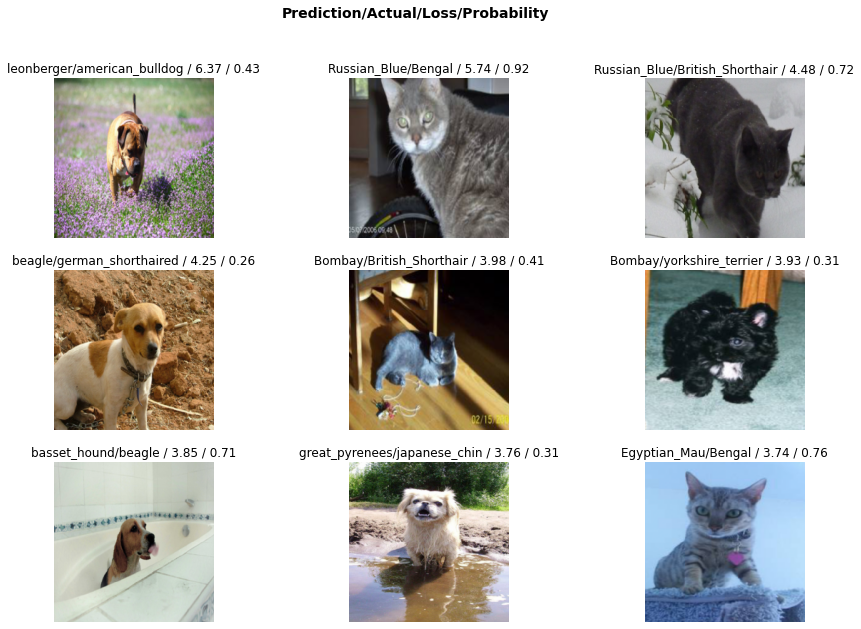

In [42]:
interp.plot_top_losses(9, figsize=(15,10))

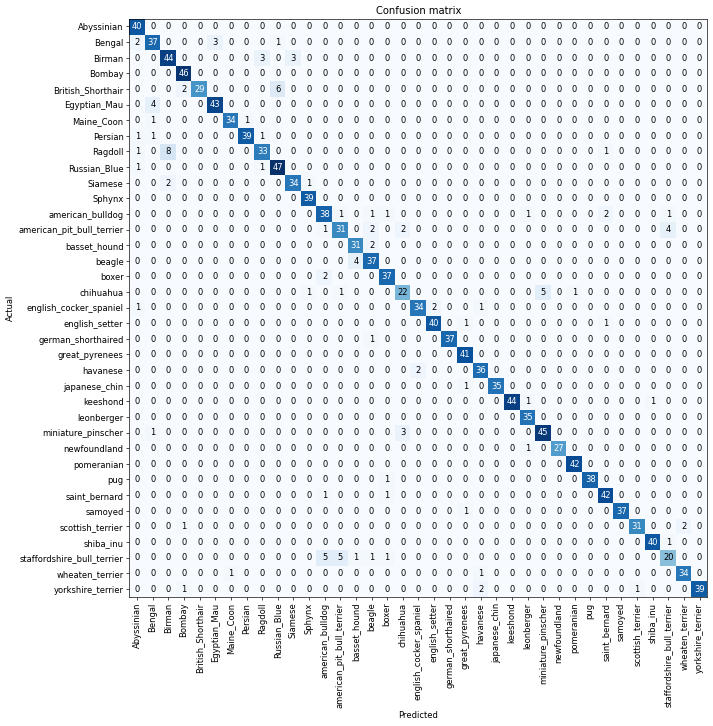

In [43]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [44]:
interp.most_confused(min_val=3)

[('Ragdoll', 'Birman', 8),
 ('British_Shorthair', 'Russian_Blue', 6),
 ('chihuahua', 'miniature_pinscher', 5),
 ('staffordshire_bull_terrier', 'american_bulldog', 5),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 5),
 ('Egyptian_Mau', 'Bengal', 4),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 4),
 ('beagle', 'basset_hound', 4),
 ('Bengal', 'Egyptian_Mau', 3),
 ('Birman', 'Ragdoll', 3),
 ('Birman', 'Siamese', 3),
 ('miniature_pinscher', 'chihuahua', 3)]

## 2.2 - Comprehensibility

We want to see what the model sees to identify whether something is a cat or a dog - here we look at the cat instance.

In [45]:
def is_cat(x): return x[0].isupper()
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=21,
    label_func=is_cat, item_tfms=Resize(224))
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.149150,0.020413,0.007442,01:05


RuntimeError: CUDA out of memory. Tried to allocate 196.00 MiB (GPU 0; 3.95 GiB total capacity; 1.26 GiB already allocated; 126.56 MiB free; 2.36 GiB reserved in total by PyTorch)

In [ ]:
learn.save('cam-1')

In [ ]:
def is_cat(x): return x[0].isupper()
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=21,
    label_func=is_cat, item_tfms=Resize(224))
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.model.cuda()
learn.load('cam-1');

In [ ]:
!wget https://www.mynorthridgevet.com/imagebank/eVetSites/DogCats/052016_EVS_CatDog5.jpg

In [ ]:
img = PILImage.create(f'052016_EVS_CatDog5.jpg')
x, = first(dls.test_dl([img]))

In [ ]:
class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o): self.stored = o.detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [ ]:
with Hook(learn.model[0]) as hook:
    with torch.no_grad(): output = learn.model.eval()(x.cuda())
    act = hook.stored

In [ ]:
class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)   
    def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [ ]:
cls = 1
with HookBwd(learn.model[0]) as hookg: # average of all layers
    with Hook(learn.model[0]) as hook:
        output = learn.model.eval()(x.cuda())
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored

In [ ]:
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)

In [ ]:
_,ax = plt.subplots()
x_dec = TensorImage(dls.train.decode((x,))[0][0])
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

The novelty with Grad-CAM is that we can use it on any layer. For example, here we use it on the output of the second-to-last ResNet group:

In [ ]:
with HookBwd(learn.model[0][-2]) as hookg: # 
    with Hook(learn.model[0][-2]) as hook:
        output = learn.model.eval()(x.cuda())
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored

In [ ]:
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)

In [ ]:
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');